In [26]:
import jax.numpy as jnp
from jax import random, grad, jit
from jax.scipy.linalg import inv, svd, eigh, det
from jax_models import visualize_observations, Lorenz96, generate_true_states, generate_gc_localization_matrix
from jax_filters import ensrf_steps, kalman_filter_process

from jax.lax import scan
import jax
from scipy.linalg import solve_discrete_are
from tqdm import tqdm
import matplotlib.pyplot as plt
from jax.tree_util import Partial


key = random.PRNGKey(3)

# System dimensions
n = 40  # System dimension
p = 2  # Observation dimension
num_steps = 1000 # number of steps
J0 = 0 # burn in period
N = 10 # Monte Carlo samples

def create_stable_matrix(n, key):
    # Generate a symmetric random matrix
    A = random.normal(key, (n, n))
    A = (A + A.T) / 2
    
    # Ensure the matrix has a spectral radius < 1 for stability
    eigenvalues, eigenvectors = eigh(A)
    scaled_eigenvalues = eigenvalues / (jnp.abs(eigenvalues).max() + 0.1)  # Scale eigenvalues to ensure stability
    A_stable = eigenvectors @ jnp.diag(scaled_eigenvalues) @ eigenvectors.T
    
    return A_stable

# Model parameters
m0 = jnp.ones((n,))
C0 = jnp.eye(n) * 1.0   # Initial state covariance matrix (P)
Q = jnp.eye(n) * 5.0    # Process noise covariance matrix (Sigma in Julia code)
R = jnp.eye(n) * 1.0    # Observation noise covariance matrix (Gamma)
inv_R = inv(R)
M = create_stable_matrix(n,key)    # State transition matrix (A)
H = jnp.eye(n)          # Observation matrix
observation_interval = 1
n_ensemble = 30

# State initialization
vd0 = m0 + random.multivariate_normal(key, jnp.zeros(n), C0)

initial_state = vd0
key, _ = random.split(key)


def state_transition_function(x):
    return jnp.dot(M, x)

def jacobian_function(x):
    return M

jac_func = Partial(jacobian_function)
A_step = Partial(state_transition_function)


observations, true_states = generate_true_states(key, num_steps, n, vd0, H, Q, R, A_step, observation_interval)

In [27]:
radius = 10
localization_matrix = generate_gc_localization_matrix(n, radius)
ensemble_init = random.multivariate_normal(key, initial_state, Q, (n_ensemble,)).T
inflation = 1
e, c = ensrf_steps(A_step, n_ensemble, ensemble_init, num_steps, observations, observation_interval, H, Q, R, localization_matrix, inflation, key)


In [4]:
# plt.pcolormesh(c[-1])
# plt.colorbar()

In [28]:
from jax_vi import KL_gaussian, log_likelihood, KL_sum

def var_cost(inflation, ensemble_init, observations, H, Q, R, localization_matrix, key, num_steps, J0):
   
    states, covariances = ensrf_steps(A_step, n_ensemble, ensemble_init, num_steps, observations, observation_interval, H, Q, R, localization_matrix, inflation, key)
    ensemble_mean = jnp.mean(states, axis=-1)  # Taking the mean across the ensemble members dimension
    key, *subkeys = random.split(key, num=N+1)
    kl_sum = KL_sum(ensemble_mean, covariances, n, A_step, Q, key, N)

    def inner_map(subkey):
        return log_likelihood(random.multivariate_normal(subkey, ensemble_mean, covariances), observations, H, R, num_steps, J0)  # Sometimes the covariances are negative definite. Fix
    cost = kl_sum - jnp.nanmean(jax.lax.map(inner_map, jnp.vstack(subkeys)))
    
    return cost

In [29]:
var_cost(inflation, ensemble_init, observations, H, Q, R, localization_matrix, key, num_steps, J0)

Array(728794.4, dtype=float32)

In [30]:
m, C, K = kalman_filter_process(A_step, jac_func, m0, C0, observations, H, Q, R)


In [31]:
from IPython.display import clear_output
from jax import grad
from tqdm.notebook import tqdm
import jax.numpy as jnp
from jax import random
import properscoring


# Modification: Use grad to compute the gradient with respect to the inflation parameter
var_cost_grad = grad(var_cost, argnums=0)

inflation_opt = 1.3 # Example starting value for inflation
alpha = 1e-6  # Learning rate
key = random.PRNGKey(0)  # Random key
N = 10  # Number of MC samples
m0 = initial_state
C0 = Q  # Initial covariance, assuming Q is your process noise covariance
localization_matrix = generate_gc_localization_matrix(n, radius)# jnp.ones((n, n)) # 
ensemble_init = random.multivariate_normal(key, initial_state, Q, (n_ensemble,)).T

crpss = []
rmses=[]
inflations = []
errs = []
true_div = []


# from jax import config
# config.update("jax_debug_nans", True)

for i in tqdm(range(50)):
    key, subkey = random.split(key)
        
    # Gradient descent step for inflation parameter
    grad_inflation = var_cost_grad(inflation_opt, ensemble_init, observations, H, Q, R, localization_matrix, subkey, num_steps, J0)
    inflation_opt -= alpha * grad_inflation  # Update inflation parameter
    
    inflations.append(inflation_opt)

    states, covariances = ensrf_steps(A_step, n_ensemble, ensemble_init, num_steps, observations, observation_interval, H, Q, R, localization_matrix, inflation_opt, key)
    ensemble_mean = jnp.mean(states, axis=-1)  # Taking the mean across the ensemble members dimension
    rmse = jnp.sqrt(jnp.mean((ensemble_mean - true_states)**2))
    rmses.append(rmse)
    crps = properscoring.crps_ensemble(true_states, states).mean(axis=1).mean()
    crpss.append(crps)
    total_kl_divergence = 0
    for t in range(num_steps):  
        kl_div_t = KL_gaussian(n, ensemble_mean[t], covariances[t],  m[t], C[t])
        total_kl_divergence += kl_div_t
    
    true_div.append(total_kl_divergence / 250)
    #clear_output(wait=True)
    


  0%|          | 0/50 [00:00<?, ?it/s]

In [32]:
true_div

[Array(nan, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, dtype=fl

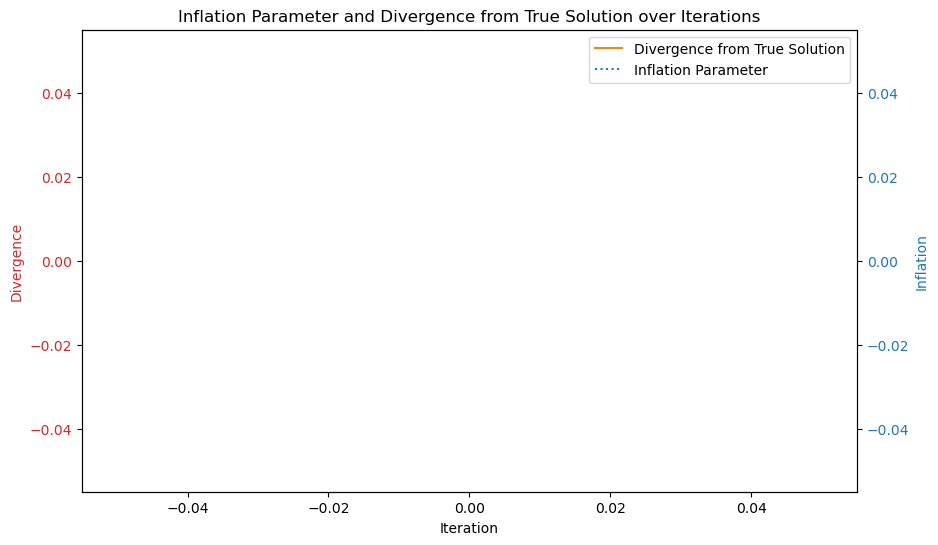

In [33]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotting the RMSE and CRPS on the primary y-axis
color = 'tab:red'
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Divergence', color=color)
ln1 = ax1.plot(true_div, label='Divergence from True Solution', color='tab:orange', linestyle='-')
ax1.tick_params(axis='y', labelcolor=color)

# Create a twin y-axis for the inflation parameter
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Inflation', color=color)
ln3 = ax2.plot(inflations, label='Inflation Parameter', color=color, linestyle=':')
ax2.tick_params(axis='y', labelcolor=color)

# Combine legends from both axes
lns = ln1 + ln3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='upper right')

plt.title('Inflation Parameter and Divergence from True Solution over Iterations')
plt.show()
